(spectrum)=
# Kurzzeitspektralanalyse bewerten

## Lernziele für den Abschnitt *Kurzzeitspektralanalyse bewerten*

<div class="admonition note" style="background: #e5f1ff; padding: 10px">
<div class="title"><b>Lernziele für den Abschnitt:</b></div>
    <ul>
        <li> Kenngrößen der Kurzzeitspektralanalyse verstehen </li>
        <li> mithilfe von Fensterung und Frequenzanalyse </li>
        <li> um Frequenzsignale zu beurteilen </li>
    </ul>
</div>

## python konfigurieren

### Module importieren

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import schemdraw
import schemdraw.elements as elm
import numpy as np
import scipy
from scipy.stats import norm
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.io import wavfile
import pandas as pd
import locale
import distutils.spawn
from distutils.spawn import find_executable
import IPython.display
from IPython.display import display, Latex, IFrame
import sounddevice as sd

print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('scipy', scipy.__version__)
print('pandas', pd.__version__)
print('locale', locale)
print('distutils.spawn', distutils.spawn)
print('IPython.display', IPython.display)
print('schemdraw', schemdraw.__version__)
print('sounddevice', sd.__version__)

matplotlib 3.7.1
numpy 1.24.2
scipy 1.10.1
pandas 1.5.3
locale <module 'locale' from '/home/franzi/.pyenv/versions/miniconda3-latest/envs/sen/lib/python3.10/locale.py'>
distutils.spawn <module 'distutils.spawn' from '/home/franzi/.pyenv/versions/miniconda3-latest/envs/sen/lib/python3.10/site-packages/setuptools/_distutils/spawn.py'>
IPython.display <module 'IPython.display' from '/home/franzi/.pyenv/versions/miniconda3-latest/envs/sen/lib/python3.10/site-packages/IPython/display.py'>
schemdraw 0.15
sounddevice 0.4.6


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
locale.setlocale(locale.LC_ALL, '')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

## Zusammenfassung Fourieranalyse

**zeitkontinuierliche, periodische Zeitfunktionen** {cite:p}`werner_digitale_2019` $\to$ im Frequenzbereich ein Linienspektrum mit den Fourier-Koeffizienten $c_k$ bei den Frequenzen $k\cdot f_0$ mit der Grundfrequenz $f_0=1/T_0$ und der Periode $T_0$ des Zeitsignals

\begin{equation}
x(t) = \sum_{-\infty}^{+\infty} c_k \cdot e^{j\cdot 2\pi \cdot f_0 \cdot k \cdot t}\text{ mit }c_k = \frac{1}{T_0}\cdot\int_{t_0}^{t_0+T_0} x(t)\cdot e^{-j\cdot 2\pi \cdot f_0 \cdot k \cdot t} dt
\end{equation}

**zeitdiskrete, periodische Funktionen: diskrete Fourier-Transformation (DFT)** $\to$ im Frequenzbereich ein Linienspektrum mit den DFT Koeffizienten $X[k]$ mit der Periode $N$ zu den normierten Frequenzen $k/N$, $k=0..N-1$, mit der normierten Grundfrequenz $1/N$ und der Periode $N$ des Zeitsignals

$\to$ DFT und ihre Inverse (IDFT) sind bis auf den Skalierungsfaktor $1/N$ symmetrisch

\begin{equation}
x[n] = \frac{1}{N}\cdot\sum_{k=0}^{N-1} X[k]\cdot e^{j\cdot 2\pi \cdot \frac{k\cdot n}{N}}\text{ und }X[k]=\sum_{n=0}^{N-1} x[n]\cdot e^{-j\cdot 2\pi \cdot\frac{k\cdot n}{N}}
\end{equation}

**zeitkontinuierliche, aperiodische Zeitfunktionen** $\to$ im Frequenzbereich das Spektrum bzgl. der Kreisfrequenz $\omega = 2\pi\cdot f$

\begin{equation}
x(t)=\frac{1}{2\pi}\cdot\int_{-\infty}^{+\infty} X(j\omega)\cdot e^{j\cdot \omega \cdot t} d\omega\text{ und }X(j\omega) = \int_{-\infty}^{+\infty} x(t)\cdot e^{-j\cdot \omega \cdot t} dt
\end{equation}

**zeitdiskrete, aperiodische Funktionen: Diskrete Fourier-Transformation (DFT)** $\to$ im Frequenzbereich ein periodisches Spektrum für die normierte Kreisfrequenz mit der Periode $2\pi$

\begin{equation}
x(t)=\frac{1}{2\pi}\int_{2\pi} X(e^{j\cdot \Omega})\cdot e^{j\Omega \cdot t} d\Omega\text{ mit }X(e^{j\Omega}) = \sum_{n=-\infty}^{+\infty} x[n]\cdot e^{-j\cdot\Omega \cdot n}
\end{equation}

<a title="wdwd, CC BY 3.0 &lt;https://creativecommons.org/licenses/by/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Diff_Fourier-Analyse.svg"><img width="512" alt="Diff Fourier-Analyse" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Diff_Fourier-Analyse.svg/512px-Diff_Fourier-Analyse.svg.png"></a>

<a href="https://commons.wikimedia.org/wiki/File:Diff_Fourier-Analyse.svg">wdwd</a>, <a href="https://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>, via Wikimedia Commons

## Kurzzeitspektralanalyse

![stft](../img/stft-overview.png)

![heatmap](../img/stft-heatmap.png)

je länger das jeweilige Fenster, desto detaillierter wird die spektrale Auflösung, gleichzeitig sinkt die zeitliche Auflösung{cite:p}`yang_signals_2009`

## Genauigkeit der DFT und Auflösung

![peaks](../img/window-resolution.png)

Breite des Hauptzipfels wird häufig in $\pi\cdot\text{rad}/N$ dargestellt $\to$ damit ist Fenster charakterisiert

Beispiel: python scipy window $\to$ Hamming-Fenster mit $N=64$ angegeben / ablesbar: 3dB-Breite $0,04\pi\cdot\text{rad/sample}$

$\to$ entspricht

\begin{equation}
\frac{0,04\pi}{1} = \frac{0,04\pi\cdot N}{N} = \frac{0,04\pi\cdot 64}{N} = \frac{2,54\pi}{N}
\end{equation}

für N = 32: 3dB-Breite $0,08\pi\cdot\text{rad/sample}$:

\begin{equation}
\frac{0,08\pi}{1} = \frac{0,08\pi\cdot N}{N} = \frac{0,04\pi \cdot 32}{N} = \frac{2,54 \pi}{N}
\end{equation}

für Rechteck-Fenster mit $N=64$: 3dB-Breite $0,03\pi\cdot\text{rad/sample}$

\begin{equation}
\frac{0,03\pi}{1}=\frac{0,03\pi N}{N} = \frac{0,03\pi\cdot 64}{N} = \frac{1,92\pi}{N}
\end{equation}

spektrale Auflösung: halbe Hauptzipfelbreite $\Delta \Omega = \frac{\Delta \omega}{f_S}$

Was bedeutet Auflösung: Unterscheidbarkeit

wenn Auflösung z. B. 10 Hz und $f_1 = 8\text{ Hz}$ und $f_2 = 18\text{ Hz}$, dann unterscheidbar

wenn $f_1 = 8\text{ Hz}$ und $f_2 = 10\text{ Hz}$, nicht unterscheidbar

## Übungsaufgaben

### Spektrum lesen

Mit dem folgenden Python-Programm wurd eine Audiodatei im Format WAVE verarbeitet. Es werden zwei Grafiken erzeugt. 

In [13]:
samplerate, data = wavfile.read('../data/audio.wav')
y = data[1:2**14]/np.max(data)
sd.play(y,samplerate)
status = sd.wait()

/tmp/ipykernel_76395/429412969.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('../data/audio.wav')


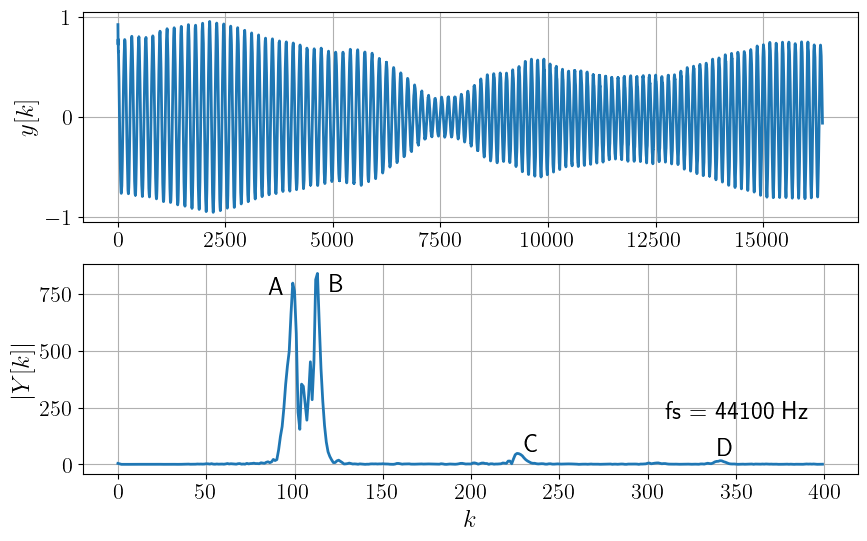

In [14]:
w = signal.windows.hann(2**14-1)
Y = fft(y*w)
ax1 = plt.subplot(211)
ax1.plot(np.linspace(0,len(y)-1,len(y)),y)
ax1.grid()
ax1.set_xlabel(r'$n$')
ax1.set_ylabel(r'$y[k]$')
ax2 = plt.subplot(212)
ax2.plot(np.linspace(0,399,400),np.abs(Y[0:400]))
ax2.grid()
ax2.set_xlabel(r'$k$')
ax2.set_ylabel(r'$\vert Y[k]\vert$')
ax2.text(310,200,'fs = '+str(samplerate)+' Hz')
ax2.text(85,750,'A')
ax2.text(120,760,'B')
ax2.text(230,50,'C')
ax2.text(340,40,'D')
plt.show()

1. Markieren Sie den Wert des Audiosignals nach 100 ms.
2. Geben Sie die Frequenz der Spektralkomponente C in Hz an. 
3. In welchem Zusammenhang stehen die Spektralkomponenten A, B, C und D?

*Lösung an der Tafel*

### Spektrale Auflösung

Ein Gütekriterium für die Spektralanalyse mit Fensterung ist die spektrale Auflösung. Geben Sie die minimale spektrale Auflösung im Falle des Hammingfensters der Länge $N$ an. *Hinweis: Breite des Hauptzipfels des Hammingfensters beträgt $8\pi/N$*

Was ist die resultierende spektrale Auflösung, wenn die Fenstergröße $N=16$ bzw. $N=32$ beträgt?

Wie beeinflusst die Fenstergröße die spektrale Auflösung?

*Lösung an der Tafel*

### Verständnis Fourieranalyse

Welche der folgenden Aussagen ist uneingeschränkt richtig? Kreuzen Sie die richtigen Antworten an.

- [ ] Das Fourierspektrum des abgetasteten Signals resultiert aus der periodischen Wiederholung des Originalspektrums mit der Periode $2\pi/T_S$.
- [ ] Die Kurzzeit-Spektralanalyse mit Fensterung beruht auf der Faltung der Fensterfolge mit dem Signal.
- [ ] Das Hamming-Fenster wird häufig eingesetzt, weil seine spektrale Auflösung besser als die des Rechteckfensters ist.
- [ ] Durch das Leckphänomen werden im DFT-Spektrum Spektralkomponenten angezeigt, die im transformierten Signalblock nicht vorhanden sind.
- [ ] Die Frequenzauflösung der DFT mit der Blocklänge 256 beträgt bei der Abtastfrequenz 8 kHz ungefährt 31 Hz.

*Lösung an der Tafel*

### Dual-Tone Multi-Frequency

![dtmf](../img/stft-dtmf.png)

Das DTMF-Verfahren {cite:p}`werner_digitale_2019` (Mehrfrequenzwahl der analogen Telefonie mit DTMF - Dual-Tone Multi-Frequency) ermöglicht die digitale Inbandsignalisierung über analoge Sprachtelefonkanäle und hat zur Ablösung der Wählscheibe durch den Tastenwahlblock beigetragen.

Nach Betätigen einer Taste wird das Wählzeichen als Tonpaar codiert und als DTMF-Signal übertragen. Das DTMF-Verfahren ist durch die International Telecommunication Union weltweit standardisiert. Es hat eine Mindestdauer von 40 ms und zwischen zwei DTMF-Signalen muss ein Abstand von mindestens 80 ms eingehalten werden.

Geben Sie das Signal $x[n]$ an, das durch Abtastung mit der Abtastfrequenz $f_S=8\text{ kHz}$ aus dem amplitudennormierten DTMF-Signal für das Wählzeichen 1 entsteht. Lassen Sie dabei die zeitliche Begrenzung außer Acht.

\begin{equation}
x_1[n] = 
\end{equation}

Welcher Zusammenhang besteht zwischen der Frequenz des zeitkontinuierlichen Signals $f$ und der normierten Kreisfrequenz $\Omega$ des zeitdiskreten Signals? Füllen Sie dazu die Tabelle für die DTMF-Frequenzen aus.

| **$f$ in Hz** | 697 | 770 | 852 | 941 | 1209 | 1336 | 1477 |
|---|---|---|---|---|---|---|---|
| **$\Omega/2\pi$** | 0,0871 | | | | | | 0,185 |

Es sei $N$ die Transformationslänge der DFT mit Rechteckfenster. Wie groß ist die spektrale Auflösung der DFT, die Frequenzauflösung $\Delta f$ in Hz, d.h. um welche Frequenzdifferenz unterscheiden sich zwei benachbarte Spektrallinien im DFT-Frequenzraster?

\begin{equation}
\Delta f = 
\end{equation}

Wie groß muss die DFT-Länge $N$ mindestens sein, damit die Frequenzauflösung der DFT den Abstand zwischen den DTMF-Tönen nicht unterschreitet?

\begin{equation}
N_{\text{min}} = 
\end{equation}

Geben Sie die DTMF-Frequenzen und zugeordnete Frequenzen gemäß dem DFT-Frequenzraster mit der DFT-Länge $N = 256$ ($f_S = 8\text{ kHz}$) an.

| **$f$ in Hz** | 697 | 770 | 852 | 941 | 1209 | 1336 | 1477 |
|---|---|---|---|---|---|---|---|
| **$k$** | 22 | | | | | | 47 |
| **$f_k$ in Hz** | 687,5 | | | | | | 1469 |
| **$\vert f-f_k\vert$ in Hz** | 9,5 | | | | | | 8 |

*Lösung an der Tafel*

```{bibliography}
:filter: docname in docnames
```